# Upload Dataset

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('Train_Data.csv')


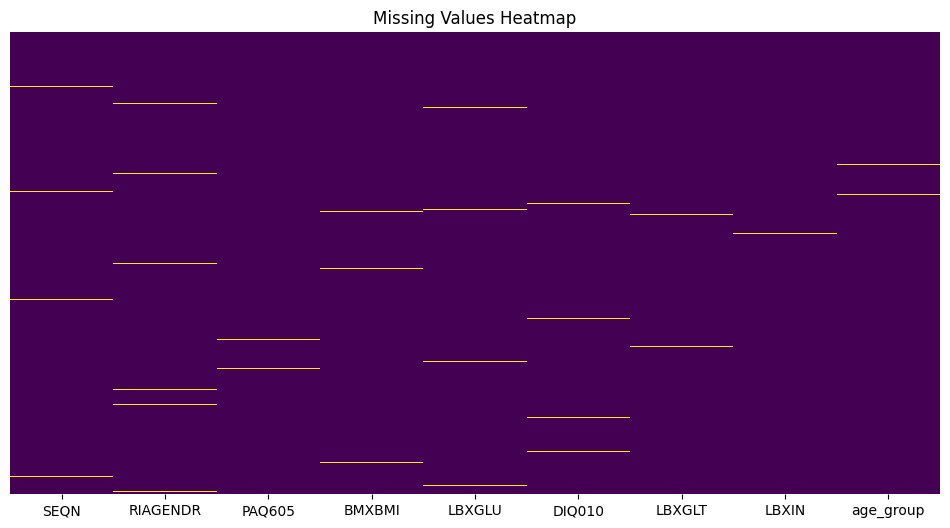

In [16]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [17]:
null_count = df.isnull().sum()
null_percentage = (null_count / len(df)) * 100


null_summary = pd.DataFrame({
    'Missing Values': null_count,
    'Percentage (%)': null_percentage
})

null_summary = null_summary[null_summary['Missing Values'] > 0]
null_summary = null_summary.sort_values(by='Missing Values', ascending=False)
print(null_summary)

           Missing Values  Percentage (%)
RIAGENDR               18        0.915565
DIQ010                 18        0.915565
BMXBMI                 18        0.915565
age_group              14        0.712106
LBXGLU                 13        0.661241
PAQ605                 13        0.661241
SEQN                   12        0.610376
LBXGLT                 11        0.559512
LBXIN                   9        0.457782


In [18]:
df['age_group'] = df['age_group'].map({'Adult': 0, 'Senior': 1})


def impute_by_matching(df, target_col, reference_cols):
    missing_rows = df[df[target_col].isnull()]
    not_missing_rows = df[df[target_col].notnull()]

    for i, row in missing_rows.iterrows():
        match = not_missing_rows.copy()
        for col in reference_cols:
            match = match[match[col] == row[col]]
        if not match.empty:
            df.at[i, target_col] = match[target_col].mode()[0]


    df[target_col] = df[target_col].fillna(df[target_col].mode()[0])
    return df


df = impute_by_matching(df, 'RIAGENDR', ['PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN', 'age_group'])
df = impute_by_matching(df, 'PAQ605', ['RIAGENDR', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN', 'age_group'])
df = impute_by_matching(df, 'age_group', ['RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT', 'LBXIN'])


print(df[['RIAGENDR', 'PAQ605', 'age_group']].isnull().sum())  # All should be 0
print(df['age_group'].unique())  # Should be [0, 1]

RIAGENDR     0
PAQ605       0
age_group    0
dtype: int64
[0. 1.]


In [19]:
def weighted_avg_knn_impute(column, window=2):
    col = column.copy()
    for i in range(len(col)):
        if pd.isnull(col[i]):
            weights = []
            values = []
            for offset in range(1, window + 1):
                for direction in [-1, 1]:  # check above and below
                    idx = i + (direction * offset)
                    if 0 <= idx < len(col) and not pd.isnull(col[idx]):
                        weight = window - offset + 1
                        weights.append(weight)
                        values.append(col[idx] * weight)
            if weights:
                col[i] = sum(values) / sum(weights)
    return col

df['SEQN'] = weighted_avg_knn_impute(df['SEQN'], window=2)
df['SEQN'] = df['SEQN'].round().astype(int)
print(df['SEQN'].isnull().sum())  # Should be 0


0


In [20]:
columns_to_impute = ['BMXBMI', 'DIQ010', 'LBXGLU', 'LBXGLT', 'LBXIN']


reference_base = ['RIAGENDR', 'PAQ605', 'age_group']


for col in columns_to_impute:
    ref_cols = [c for c in columns_to_impute if c != col] + reference_base
    df = impute_by_matching(df, col, ref_cols)

print(df[columns_to_impute].isnull().sum())

BMXBMI    0
DIQ010    0
LBXGLU    0
LBXGLT    0
LBXIN     0
dtype: int64


In [21]:
!pip install catboost


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import numpy as np


X = df.drop(columns=['age_group', 'SEQN'])  # Drop target + ID column
y = df['age_group']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling for SVM only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Step 5: Train, test, and cross-validate
results = []

for name, model in models.items():
    print(f"\n=== {name} ===")

    # Use scaled data for SVM, original for others
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        cv_scores = cross_val_score(model, scaler.transform(X), y, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    test_acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Cross-Validation Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Cross-Validation Std Dev: {cv_scores.std():.4f}")

    results.append({
        'Model': name,
        'Test Accuracy': test_acc,
        'CV Mean Accuracy': cv_scores.mean(),
        'CV Std Dev': cv_scores.std()
    })




=== SVM ===
Test Accuracy: 0.8477
Cross-Validation Mean Accuracy: 0.8403
Cross-Validation Std Dev: 0.0025

=== Random Forest ===
Test Accuracy: 0.8426
Cross-Validation Mean Accuracy: 0.8347
Cross-Validation Std Dev: 0.0076

=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Test Accuracy: 0.8198
Cross-Validation Mean Accuracy: 0.8199
Cross-Validation Std Dev: 0.0131

=== AdaBoost ===
Test Accuracy: 0.8452
Cross-Validation Mean Accuracy: 0.8388
Cross-Validation Std Dev: 0.0054

=== CatBoost ===
Test Accuracy: 0.8426
Cross-Validation Mean Accuracy: 0.8388
Cross-Validation Std Dev: 0.0081


In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       338
         1.0       0.33      0.11      0.16        56

    accuracy                           0.84       394
   macro avg       0.60      0.54      0.54       394
weighted avg       0.79      0.84      0.81       394



In [24]:
from sklearn.metrics import f1_score, classification_report

for name, model in models.items():
    print(f"\n=== {name} ===")

    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        cv_f1 = cross_val_score(model, scaler.transform(X), y, cv=5, scoring='f1')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')

    test_f1 = f1_score(y_test, y_pred)

    print(f"Test F1-Score: {test_f1:.4f}")
    print(f"Cross-Validation F1 Mean: {cv_f1.mean():.4f}")
    print(f"Cross-Validation F1 Std Dev: {cv_f1.std():.4f}")

    results.append({
        'Model': name,
        'Test F1-Score': test_f1,
        'CV Mean F1': cv_f1.mean(),
        'CV F1 Std': cv_f1.std()
    })

    # Detailed report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Step 6: Compare models
results_df = pd.DataFrame(results)
print("\n=== F1 Score Comparison ===")
print(results_df.sort_values(by='CV Mean F1', ascending=False))



=== SVM ===
Test F1-Score: 0.0625
Cross-Validation F1 Mean: 0.0585
Cross-Validation F1 Std Dev: 0.0427
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92       338
         1.0       0.25      0.04      0.06        56

    accuracy                           0.85       394
   macro avg       0.56      0.51      0.49       394
weighted avg       0.77      0.85      0.80       394


=== Random Forest ===
Test F1-Score: 0.1622
Cross-Validation F1 Mean: 0.1871
Cross-Validation F1 Std Dev: 0.0594
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       338
         1.0       0.33      0.11      0.16        56

    accuracy                           0.84       394
   macro avg       0.60      0.54      0.54       394
weighted avg       0.79      0.84      0.81       394


=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:52:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Test F1-Score: 0.2022
Cross-Validation F1 Mean: 0.2654
Cross-Validation F1 Std Dev: 0.0474
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90       338
         1.0       0.27      0.16      0.20        56

    accuracy                           0.82       394
   macro avg       0.57      0.54      0.55       394
weighted avg       0.78      0.82      0.80       394


=== AdaBoost ===
Test F1-Score: 0.1408
Cross-Validation F1 Mean: 0.1547
Cross-Validation F1 Std Dev: 0.0656
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.91       338
         1.0       0.33      0.09      0.14        56

    accuracy                           0.85       394
   macro avg       0.60      0.53      0.53       394
weighted avg       0.79      0.85      0.80       394


=== CatBoost ===
Test F1-Score: 0.1622
Cross-Validation F1 Mean: 0.2426
Cross-Validation F1 Std Dev

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)


grid.fit(X_train, y_train)

# Step 5: Best results
print("✅ Best Parameters:", grid.best_params_)
print("🏆 Best CV F1-Score:", grid.best_score_)


best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)
test_f1 = f1_score(y_test, y_pred)
print(f"\n🧪 Test F1-Score (Best XGBoost): {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
🏆 Best CV F1-Score: 0.33318437778681115

🧪 Test F1-Score (Best XGBoost): 0.1026

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       338
         1.0       0.18      0.07      0.10        56

    accuracy                           0.82       394
   macro avg       0.52      0.51      0.50       394
weighted avg       0.76      0.82      0.79       394



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:59:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")


scale_pos_weight = 5.09


In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, classification_report


xgb_weighted = XGBClassifier(
    n_estimators=150,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


xgb_weighted.fit(X_train, y_train)
y_pred = xgb_weighted.predict(X_test)


print("✅ Weighted XGBoost Classification Report:")
print(classification_report(y_test, y_pred))

test_f1 = f1_score(y_test, y_pred)
print(f"🏁 Test F1-Score: {test_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:05:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Weighted XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.88       338
         1.0       0.24      0.23      0.24        56

    accuracy                           0.79       394
   macro avg       0.56      0.56      0.56       394
weighted avg       0.78      0.79      0.79       394

🏁 Test F1-Score: 0.2364


In [28]:
import pandas as pd

test_df = pd.read_csv("Test_Data.csv")
X_final_test = test_df.drop(columns=['SEQN'], errors='ignore')


final_predictions = xgb_weighted.predict(X_final_test)
submission_df = pd.DataFrame({'age_group': final_predictions.astype(int)})
submission_df.to_csv("predicted_age_group.csv", index=False)

print("✅ Predictions saved to 'predicted_age_group.csv'")


✅ Predictions saved to 'predicted_age_group.csv'


trying to improve my score now

In [42]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


In [43]:
probs = xgb_weighted.predict_proba(X_test)[:, 1]
y_pred_adjusted = (probs >= 0.3).astype(int)  # Lowering threshold helps recall for class 1


In [44]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_smote).value_counts())


After SMOTE:
age_group
0.0    1314
1.0    1314
Name: count, dtype: int64


In [45]:
xgb_smote = XGBClassifier(
    n_estimators=150,
    max_depth=7,
    learning_rate=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_smote.fit(X_train_smote, y_train_smote)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:58:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [46]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Predict probabilities
probs = xgb_smote.predict_proba(X_test)[:, 1]

# Try a lower threshold (like 0.3)
threshold = 0.3
y_pred_thresh = (probs >= threshold).astype(int)

# Evaluate
print(f"\n🏁 F1-Score (threshold={threshold}):", f1_score(y_test, y_pred_thresh))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_thresh))



🏁 F1-Score (threshold=0.3): 0.2676056338028169

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84       338
         1.0       0.22      0.34      0.27        56

    accuracy                           0.74       394
   macro avg       0.55      0.57      0.55       394
weighted avg       0.79      0.74      0.76       394



In [47]:
# Predict on final test data
final_test_probs = xgb_smote.predict_proba(X_final_test)[:, 1]
final_preds = (final_test_probs >= threshold).astype(int)

# Save predictions
submission_df = pd.DataFrame({'age_group': final_preds})
submission_df.to_csv("predicted_age.csv", index=False)

print("✅ Final predictions saved with threshold-tuned XGBoost + SMOTE")


✅ Final predictions saved with threshold-tuned XGBoost + SMOTE


In [49]:
import joblib

# After SMOTE + XGBoost training
joblib.dump(xgb_smote, "xgb_final_model.pkl")


['xgb_final_model.pkl']